In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
np.set_printoptions(threshold=33500)
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon, GeometryCollection
from shapely.ops import cascaded_union
import shapely.wkt
from shapely.validation import explain_validity,make_valid
from datetime import datetime, timedelta
from collections import OrderedDict
import fiona
from matplotlib.path import Path
from timezonefinder import TimezoneFinder
import pytz
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
polygons_2020 = gpd.read_file('AllFires_VIIRS_per_overpass_2020.geojson')
#polygons_2020 = gpd.read_file('AllFires_VIIRS_per_overpass_SCUCZU_2020.geojson')

In [ ]:
fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(111,projection=ccrs.LambertConformal())
#ax.set_extent([-54.6, -55, 38.4,38.75])
polygons_2020.plot(column= 'Fire Name', cmap='tab20',ax=ax, legend=True)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
            linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.title('Polys')
plt.show()

In [ ]:
polys_removed = polygons_2020.iloc[np.where(polygons_2020['Current Day']>= '2020-07-01')].reset_index(drop=True)
days = np.arange(np.datetime64('2020-07-01'), np.datetime64('2021-01-01'))
#days = np.arange(np.datetime64('2020-08-20'), np.datetime64('2020-08-21'))
#loop over all the days
total_length = 0
for ii in range(len(days)):
    print(days[ii])
    today = polys_removed.iloc[np.where(polys_removed['Current Day']==str(days[ii]))]
    overpasses = np.unique(polys_removed['Current Overpass'].values) # np.array([1048])#  
    
    for jj in range(len(overpasses)):
        overpass = today.iloc[np.where(today['Current Overpass']==overpasses[jj])]
        if len(overpass)>0:
            overlay = gpd.overlay(overpass, overpass, how='intersection',keep_geom_type=False)
            if len(overlay)>0:
                intersects = np.where(overlay['Incident Number_1'].values!=overlay['Incident Number_2'].values)
                intersections = overlay.iloc[intersects].reset_index(drop=True)
            
                if len(intersections) >0:
                    print("removing intersections")
                    #intersections=intersections.set_index(['Incident Number_1'])
                    #print(intersections.index.duplicated())
                    total_length = total_length+(len(intersections)/2)
                    print(total_length)

# LOOP for all cases

In [ ]:
polys_removed = polygons_2020.iloc[np.where(polygons_2020['Current Day']>= '2020-07-01')].reset_index(drop=True)
#days = np.arange(np.datetime64('2020-07-01'), np.datetime64('2021-01-01'))
days = np.arange(np.datetime64('2020-08-20'), np.datetime64('2020-08-21'))
#loop over all the days
for ii in range(len(days)):
    print(days[ii])
    today = polys_removed.iloc[np.where(polys_removed['Current Day']==str(days[ii]))]
    overpasses = np.unique(polys_removed['Current Overpass'].values) #np.array([1048])
    
    for jj in range(len(overpasses)):
        overpass = today.iloc[np.where(today['Current Overpass']==overpasses[jj])]
        if len(overpass)>0:
            overlay = gpd.overlay(overpass, overpass, how='intersection',keep_geom_type=False)
            if len(overlay)>0:
                intersects = np.where(overlay['Incident Number_1'].values!=overlay['Incident Number_2'].values)
                intersections = overlay.iloc[intersects].reset_index(drop=True)
            
                if len(intersections) >0:
                    print("removing intersections")
                                        
                    for kk in range(len(intersections)):
                        fires_processed = []
                        intersection_poly = intersections.iloc[kk:kk+1].reset_index(drop=True)
                        intersection_poly_buffer= intersections.iloc[kk:kk+1].buffer(300).reset_index(drop=True)
                        
                        tic = datetime.now()
                        name1 = intersections['Incident Number_1'].iloc[kk]
                        name2 = intersections['Incident Number_2'].iloc[kk]

                        #locations in the output dataframe we want to change
                        location1 = np.where((polys_removed['Incident Number']==name1)&
                                            (polys_removed['Current Day']==str(days[ii]))&
                                            (polys_removed['Current Overpass']==overpasses[jj]))[0]
                        location2 = np.where((polys_removed['Incident Number']==name2)&
                                            (polys_removed['Current Day']==str(days[ii]))&
                                            (polys_removed['Current Overpass']==overpasses[jj]))[0]                 
                        #print(name1, name2)
                        print(location1, location2)
                        
                        if [location1, location2] in fires_processed:
                                continue
                        
                        fire1 = polys_removed.iloc[location1].reset_index(drop=True)
                        fire2 = polys_removed.iloc[location2].reset_index(drop=True)
                        """print(polys.loc[np.array([location1[0],location2[0]])])
                        print(fire1)
                        print(fire2)"""
                    
                        print('removing disputed territory')
                        fire1_undisputed = fire1.difference(intersection_poly_buffer)
                        fire2_undisputed = fire2.difference(intersection_poly_buffer)
                        
                        if fire1_undisputed.iloc[0].is_empty:
                            fire1_undisputed = fire1['geometry']
                        if fire2_undisputed.iloc[0].is_empty:
                            fire2_undisputed=fire2['geometry']
                        #print(fire1_undisputed, fire1_undisputed.is_empty)
                        
                        #dist1 = fire1_undisputed.distance(intersection_poly)
                        #dist2 = fire2_undisputed.distance(intersection_poly)
                        
                        cent1 = fire1_undisputed.centroid
                        cent2=fire2_undisputed.centroid
                        
                        dist1 = cent1.distance(intersection_poly)
                        dist2 = cent2.distance(intersection_poly)
                        
                        print(dist1,dist2)
                        
                        if dist1.values>dist2.values:
                            print('disputed territory belongs to fire2')
                            polys_removed['geometry'].iloc[location1] = fire1_undisputed
                            polys_removed['geometry'].iloc[location2] = fire2['geometry'].values
                            
                        elif dist2.values>dist1.values:
                            print('disputed territory belongs to fire1')
                            polys_removed['geometry'].iloc[location1] = fire1['geometry'].values
                            polys_removed['geometry'].iloc[location2] = fire2_undisputed
                            
                        else:
                            print('no fire has claim to this territory')
                            polys_removed['geometry'].iloc[location1] = fire1_undisputed
                            polys_removed['geometry'].iloc[location2] = fire2_undisputed
                           
                        toc=datetime.now()
                        print(toc-tic)
                        fires_processed.append([location1, location2])
                        
        
                        

                        
                      
    
"""july1 = polygons_2020.iloc[np.where((polygons_2020['Current Day'] =='2020-08-16')&
                                  (polygons_2020['Current Overpass']==1912))]
print(july1)"""

In [ ]:
"""aug20_removed = polys_removed.iloc[np.where((polys_removed['Current Day'] =='2020-08-20')&
                                           (polys_removed['Current Overpass'] ==1048))]"""

aug20_removed = polys_removed.iloc[np.where((polys_removed['Current Day'] =='2020-08-20'))]
fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(111,projection=ccrs.LambertConformal())
ax.set_extent([-54, -55, 38,39])
aug20_removed.plot(column= 'Fire Name', cmap='tab20',ax=ax)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
            linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.title('Separated Polys')
plt.show()

In [ ]:
  #plot the disputed and undisputed territories
                        fig = plt.figure(figsize=(15,10))
                        ax= fig.add_subplot(111,projection=ccrs.LambertConformal())
                        #ax.set_extent([-54.6, -55, 38.4,38.75])
                        intersection_poly_buffer.plot(color='k', ax=ax)
                        polys_removed.iloc[location1].buffer(150).plot(color='m', ax=ax)
                        polys_removed.iloc[location2].buffer(150).plot(color='y',ax=ax)
                        fire1_undisputed.plot(color='r',ax=ax)
                        fire2_undisputed.plot(color='g',ax=ax)
                        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
                            linewidth=2, color='gray', alpha=0.5, linestyle='--')
                        gl.top_labels = False
                        gl.right_labels = False
                        plt.title('Aug 20th Original Polys')
                        plt.show()

In [ ]:
#aug20 = polys.iloc[np.where((polys['Current Day'] =='2020-08-20')&(polys['Current Overpass'] ==1048))]
aug20_removed = polys_removed.iloc[np.where((polys_removed['Current Day'] =='2020-08-20')&(polys_removed['Current Overpass'] ==1048))]

In [ ]:
"""fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(111,projection=ccrs.LambertConformal())
ax.set_extent([-54, -55, 38,39])
aug20.plot(column='Fire Name',ax=ax,cmap='tab20')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
        linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.title('Aug 20th Original Polys')
plt.show()
"""

fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(111,projection=ccrs.LambertConformal())
aug20_removed.plot(column='Fire Name',ax=ax,cmap='tab20')
ax.set_extent([-54, -55, 38,39])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
        linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.title('Aug 20th Overlaps Removed')
plt.show()

## Plot the whole test case day

In [ ]:
#aug20 = polys.iloc[np.where((polys['Current Day'] =='2020-08-20'))]
aug20_removed = polys_removed.iloc[np.where((polys_removed['Current Day'] =='2020-08-20'))]
"""scu = polys_removed.iloc[np.where((polys_removed['Current Day'] =='2020-08-20')&
                                  (polys_removed['Fire Name'] =='SCU LIGHTNING COMPLEX'))]
czu = polys_removed.iloc[np.where((polys_removed['Current Day'] =='2020-08-20')&(polys_removed['Fire Name'] =='CZU AUG LIGHTNING'))]"""

In [ ]:
"""fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(111,projection=ccrs.LambertConformal())
ax.set_extent([-54, -55, 38,39])
aug20.plot(column='Fire Name',ax=ax,cmap='tab20')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
        linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.title('Aug 20th Original Polys')
plt.show()"""


fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(111,projection=ccrs.LambertConformal())
aug20_removed.plot(column='Fire Name',ax=ax,cmap='tab20', legend=True)
#ax.set_extent([-54, -55, 38,39])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
        linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.title('Aug 20th Overlaps Removed')
plt.show()



In [ ]:
#days = np.arange(np.datetime64('2020-07-01'), np.datetime64('2021-01-01'))
days = np.arange(np.datetime64('2020-08-20'), np.datetime64('2020-08-21'))
#loop over all the days
for ii in range(len(days)):
    print(days[ii])
    today = polys.iloc[np.where(polys['Current Day']==str(days[ii]))]
    overpasses = np.unique(polys['Current Overpass'].values)
    
    for jj in range(len(overpasses)):
        overpass = today.iloc[np.where(today['Current Overpass']==overpasses[jj])]
        if len(overpass)>0:
            overlay = gpd.overlay(overpass, overpass, how='union',keep_geom_type=False)
            print(overlay)
            """if len(overlay)>0:
                intersects = np.where(overlay['Fire Name_1'].values!=overlay['Fire Name_2'].values)
                intersections = overlay.iloc[intersects]
                print(intersections)
            
                if len(intersections) >0:
                    print("removing intersections")
                    print(intersections)"""
                    
                    
                
    
"""july1 = polygons_2020.iloc[np.where((polygons_2020['Current Day'] =='2020-08-16')&
                                  (polygons_2020['Current Overpass']==1912))]
print(july1)"""

# TEST CASE

In [ ]:
[ 724.  730.  736.  742.  748.  754.  800.  806.  812.  818.  824.  830.
  836.  842.  848.  854.  900.  906.  912.  918.  924.  930.  936.  942.
  948.  954. 1000. 1006. 1012. 1018. 1024. 1030. 1036. 1042. 1048. 1054.
 1100. 1106. 1112. 1118. 1124. 1130. 1824. 1830. 1836. 1842. 1848. 1854.
 1900. 1906. 1912. 1918. 1924. 1930. 1936. 1942. 1948. 1954. 2000. 2006.
 2012. 2018. 2024. 2030. 2036. 2042. 2048. 2054. 2100. 2106. 2112. 2118.
 2124. 2130. 2136. 2142. 2148. 2154. 2200. 2206. 2212. 2218.]

In [ ]:
polys = polygons_2020.iloc[np.where(polygons_2020['Current Day']>= '2020-07-01')].reset_index(drop=True)

overpass = polys.iloc[np.where((polys['Current Day'] =='2020-08-20')&
                                  (polys['Current Overpass']==1048))]
overlay = gpd.overlay(overpass, overpass, how='intersection',keep_geom_type=False)
print(overlay)

In [ ]:
intersects = np.where(overlay['Incident Number_1'].values!=overlay['Incident Number_2'].values)
intersections = overlay.iloc[intersects].reset_index(drop=True)
print(intersections)

#print(np.unique(intersections[['Fire Name_1', 'Fire Name_2']]))


In [ ]:
scu_czu_intersection = intersections.loc[(np.where((intersections['Fire Name_1'] =='SCU LIGHTNING COMPLEX')&
                                          (intersections['Fire Name_2'] =='CZU AUG LIGHTNING')))].reset_index(drop=True)
scu_czu_intersection_buffered = intersections.loc[(np.where((intersections['Fire Name_1'] =='SCU LIGHTNING COMPLEX')&
                                          (intersections['Fire Name_2'] =='CZU AUG LIGHTNING')))].buffer(300).reset_index(drop=True)

scu = overpass.iloc[np.where(overpass['Fire Name'] =='SCU LIGHTNING COMPLEX')].reset_index(drop=True)
czu = overpass.iloc[np.where(overpass['Fire Name'] =='CZU AUG LIGHTNING')].reset_index(drop=True)

#remove the intersection
print(scu_czu_intersection)

In [ ]:
tic = datetime.now()
czu_undisputed = czu.difference(scu_czu_intersection_buffered)
scu_undisputed = scu.difference(scu_czu_intersection_buffered)
toc = datetime.now()
print(toc-tic)

In [ ]:
dist_czu = czu_undisputed.distance(scu_czu_intersection)
dist_scu = scu_undisputed.distance(scu_czu_intersection)
print(dist_czu, dist_scu)

if dist_czu.values>dist_scu.values:
    print('disputed territory belongs to SCU')
    scu= scu
    czu=czu_undisputed
else:
    print('disputed territory belongs to CZU')
    scu=scu_undisputed
    czu=czu

In [ ]:
czu.plot()

In [ ]:
fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(111,projection=ccrs.LambertConformal())
#scu_czu_intersection_buffered.plot(color='g',ax=ax)
scu_undisputed.plot(color='r',ax=ax)
czu_undisputed.plot(color='b',ax=ax)
#ax.set_extent([-54.9, -54.85, 38.55,38.75])

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
                    linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.title('Test')
plt.show()

In [ ]:
july1.loc[july1['Fire Name']=='QUAIL'].plot(column='Current Overpass',legend=True)


In [ ]:
july1.loc[july1['Fire Name']=='CASSADORE SPRINGS'].plot(column='Current Overpass')

In [ ]:
overlay = gpd.overlay(july1,july1, how='intersection')
print(overlay)
print(overlay[['Fire Name_1','Fire Name_2']].values)

In [ ]:
intersects = np.where(overlay['Fire Name_1'].values!=overlay['Fire Name_2'].values)
intersections = overlay.iloc[intersects]
print(intersections)

In [ ]:
intersections.plot()

In [ ]:
fires_processed = []
print(fires_processed)
fires_processed.append([27,28])
print(fires_processed)
fires_processed.append([29,30])
print(fires_processed)
this_fire = 27
that_fire = 28

if [this_fire, that_fire] in fires_processed:
    print('hi')

# Look at CZU/SCU with expanded radius and explode

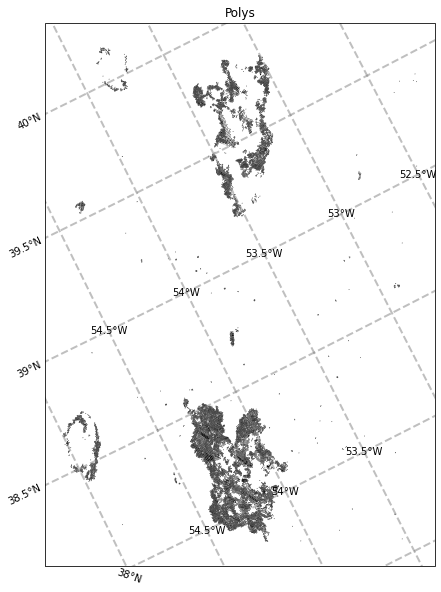

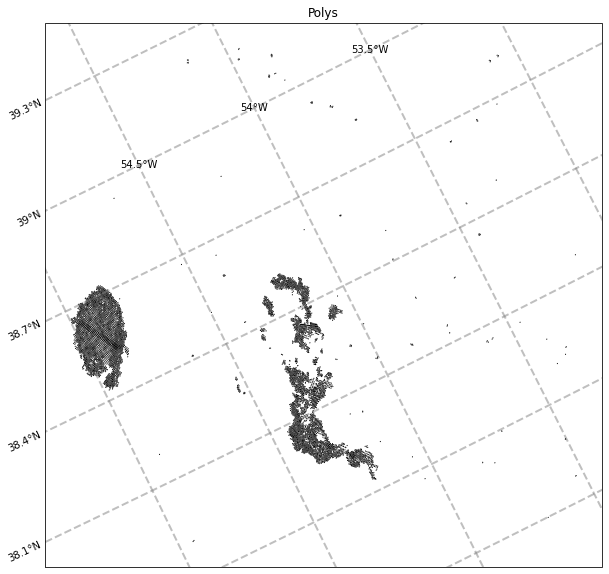

In [8]:
#plot it to see what the problem is
polygons_2020 = gpd.read_file('AllFires_VIIRS_per_overpass_SCUCZU_2020.geojson')

fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(111,projection=ccrs.LambertConformal())
#ax.set_extent([-54.6, -55, 38.4,38.75])
polygons_2020.loc[np.where(polygons_2020['Fire Name']=='SCU LIGHTNING COMPLEX')].plot(column= 'Fire Name', color='k',ax=ax, legend=True)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
            linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.title('Polys')
plt.show()

fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(111,projection=ccrs.LambertConformal())
#ax.set_extent([-54.6, -55, 38.4,38.75])
polygons_2020.loc[np.where(polygons_2020['Fire Name']=='CZU AUG LIGHTNING')].plot(column= 'Fire Name', color='k',ax=ax, legend=True)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
            linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.title('Polys')
plt.show()

In [ ]:
print(polygons_2020['Current Day'].values)

In [3]:
polys_removed = polygons_2020.iloc[np.where(polygons_2020['Current Day']>= '2020-07-01')].reset_index(drop=True)
#days = np.arange(np.datetime64('2020-07-01'), np.datetime64('2021-01-01'))
days = np.arange(np.datetime64('2020-08-16'), np.datetime64('2020-09-22'))
#loop over all the days
for ii in range(len(days)):
    print(days[ii])
    today = polys_removed.iloc[np.where(polys_removed['Current Day']==str(days[ii]))]
    overpasses = np.unique(polys_removed['Current Overpass'].values) # np.array([1048])#
    
    for jj in range(len(overpasses)):
        overpass = today.iloc[np.where(today['Current Overpass']==overpasses[jj])]
        overpass_exploded = overpass.explode()
        
        if len(overpass)>0:
            #overlay = gpd.overlay(overpass, overpass, how='intersection',keep_geom_type=False)
            overlay = gpd.overlay(overpass_exploded, overpass_exploded, how='intersection',keep_geom_type=False)

            if len(overlay)>0:
                intersects = np.where(overlay['Incident Number_1'].values!=overlay['Incident Number_2'].values)
                intersections = overlay.iloc[intersects].reset_index(drop=True)
                
                if len(intersections) >0:
                    #print("removing intersections")
                                        
                    for kk in range(len(intersections)):
                        fires_processed = []
                        intersection_poly = intersections.iloc[kk:kk+1].reset_index(drop=True)
                        intersection_poly_buffer= intersections.iloc[kk:kk+1].buffer(2000).reset_index(drop=True)
                        
                        tic = datetime.now()
                        name1 = intersections['Incident Number_1'].iloc[kk]
                        name2 = intersections['Incident Number_2'].iloc[kk]

                        #locations in the output dataframe we want to change
                        location1 = np.where((polys_removed['Incident Number']==name1)&
                                            (polys_removed['Current Day']==str(days[ii]))&
                                            (polys_removed['Current Overpass']==overpasses[jj]))[0]
                        location2 = np.where((polys_removed['Incident Number']==name2)&
                                            (polys_removed['Current Day']==str(days[ii]))&
                                            (polys_removed['Current Overpass']==overpasses[jj]))[0]                 
                        #print(name1, name2)
                        #print(location1, location2)
                        
                        if [location1, location2] in fires_processed:
                                continue
                        
                        fire1 = polys_removed.iloc[location1].reset_index(drop=True)
                        fire2 = polys_removed.iloc[location2].reset_index(drop=True)
                        #print(polys.loc[np.array([location1[0],location2[0]])])
                        #print(fire1)
                        #print(fire2)
                    
                        #print('removing disputed territory')
                        fire1_undisputed = fire1.difference(intersection_poly_buffer)
                        fire2_undisputed = fire2.difference(intersection_poly_buffer)
                        
                        """if fire1_undisputed.iloc[0].is_empty:
                            fire1_undisputed = fire1['geometry']
                        if fire2_undisputed.iloc[0].is_empty:
                            fire2_undisputed=fire2['geometry']"""
                        #print(fire1_undisputed, fire1_undisputed.is_empty)
                        
                        #dist1 = fire1_undisputed.distance(intersection_poly)
                        #dist2 = fire2_undisputed.distance(intersection_poly)
                        
                        cent1 = fire1_undisputed.centroid
                        cent2=fire2_undisputed.centroid
                        
                        dist1 = cent1.distance(intersection_poly)
                        dist2 = cent2.distance(intersection_poly)
                        
                        #print(dist1,dist2)
                        
                        if dist1.values>dist2.values:
                            #print('disputed territory belongs to fire2')
                            polys_removed['geometry'].iloc[location1] = fire1_undisputed
                            polys_removed['geometry'].iloc[location2] = fire2['geometry'].values
                            
                        elif dist2.values>dist1.values:
                            #print('disputed territory belongs to fire1')
                            polys_removed['geometry'].iloc[location1] = fire1['geometry'].values
                            polys_removed['geometry'].iloc[location2] = fire2_undisputed
                            
                        else:
                            #print('no fire has claim to this territory')
                            polys_removed['geometry'].iloc[location1] = fire1_undisputed
                            polys_removed['geometry'].iloc[location2] = fire2_undisputed
                           
                        toc=datetime.now()
                        #print(toc-tic)
                        fires_processed.append([location1, location2])


2020-08-16
2020-08-17
2020-08-18
2020-08-19
2020-08-20
2020-08-21
2020-08-22
2020-08-23
2020-08-24
2020-08-25
2020-08-26
2020-08-27
2020-08-28
2020-08-29
2020-08-30
2020-08-31
2020-09-01
2020-09-02


AttributeError: 'NoneType' object has no attribute 'type'

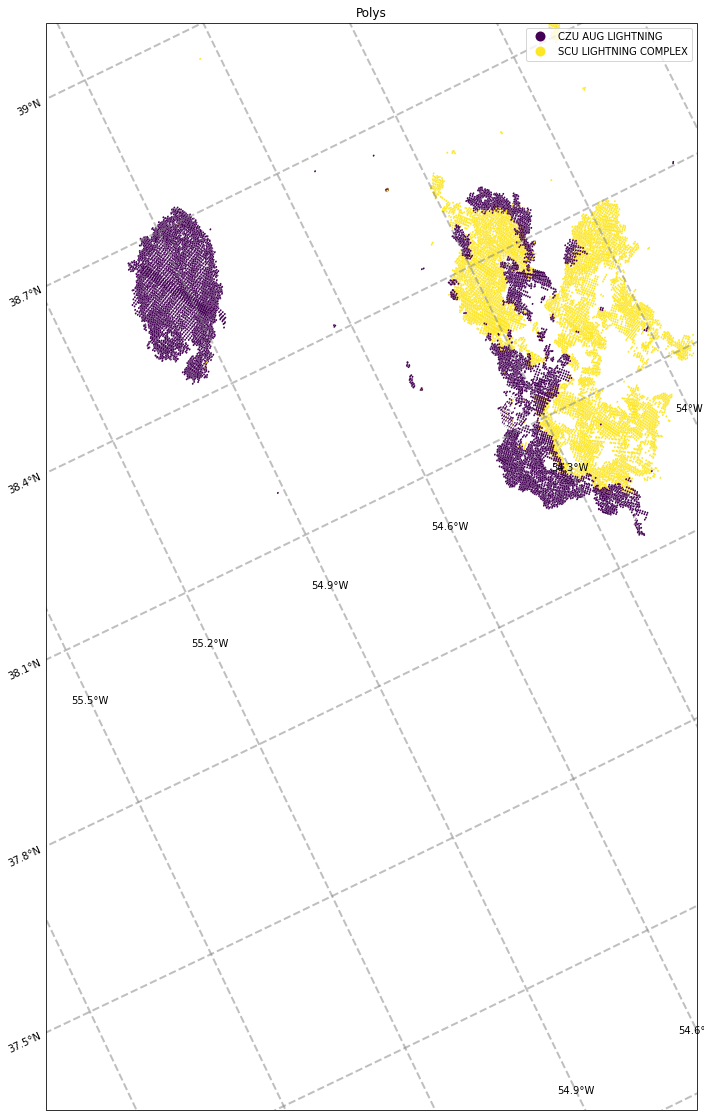

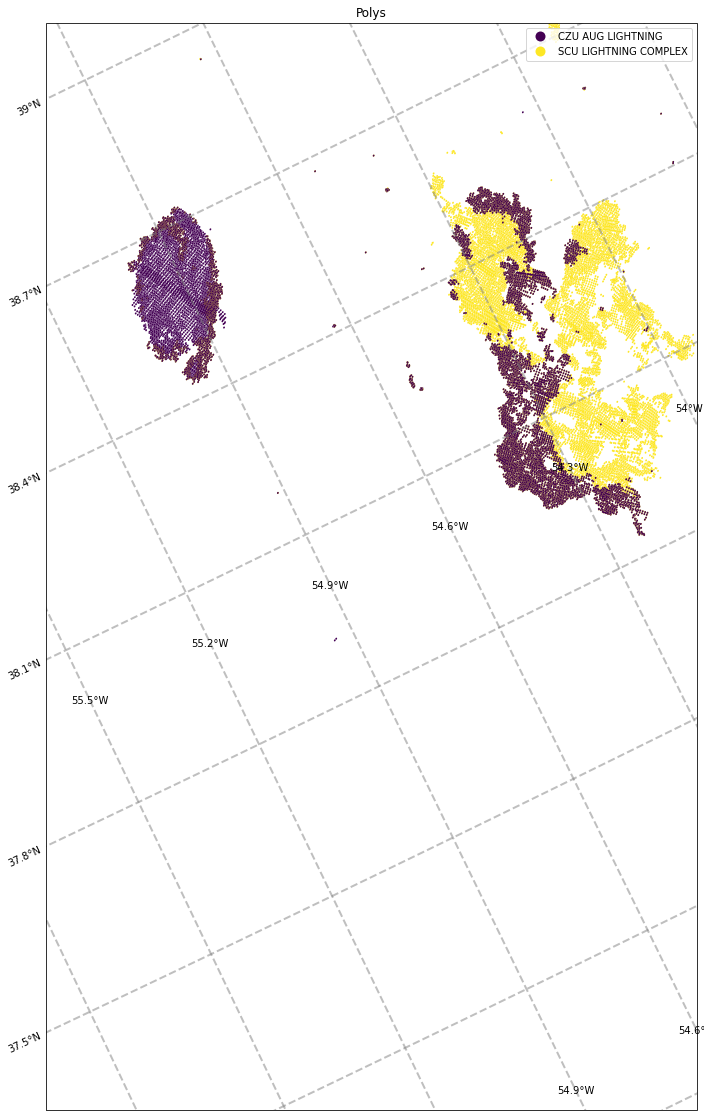

In [9]:
aug20_removed = polys_removed.loc[np.where((polys_removed['Current Day']<='2020-08-31'))]


fig = plt.figure(figsize=(25,20))
ax= fig.add_subplot(111,projection=ccrs.LambertConformal())
ax.set_extent([-54.6, -55, 37,39])
#intersections['geometry'].buffer(1000).plot(ax=ax,color='k',alpha=0.5)
aug20_removed.plot(column= 'Fire Name', cmap='viridis',ax=ax, legend=True)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
            linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.title('Polys')
plt.show()

fig = plt.figure(figsize=(25,20))
ax= fig.add_subplot(111,projection=ccrs.LambertConformal())
ax.set_extent([-54.6, -55, 37,39])
#intersections['geometry'].buffer(1000).plot(ax=ax,color='k',alpha=0.5)
polygons_2020.plot(column= 'Fire Name', cmap='viridis',ax=ax, legend=True)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
            linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.title('Polys')
plt.show()